# Import Libraries and Load data

## import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load the data

In [2]:
initial_data = pd.read_csv("/content/gdrive/MyDrive/dataset.csv")
print (len(initial_data))
initial_data.head(3)

1048576


,Sample Number,I-CH,Time,Q CH,ACP
0,-524288,7F7B,-26.214308 ms,FF76,0
1,-524287,7F7B,-26.214258 ms,FF76,0
2,-524286,7F7B,-26.214208 ms,FF76,0


* initial data contain over 1 million entries!

column  | description 
--------|----------------------
Sample Number | - 
I-CH | In phase component of the radar signal
Time | time stamp
Q CH | Quadrature component of the radar signal
ACP | Azimuth Counter Pulse state

## Parameters

ACP :- Azimuth Counter Pulse

CPI :- Coherent Processing Interval

.

The following parameters are given
* pulse repetition interval = 900$\mu s$
* actual pulse transmission/reception time = 600$\mu s$
* radar blind period = 14$\mu s$
* sampling frequency = $4MHz$
* number of erronous samples = 10650
* ACPs per revolution = 4096
* oversampled signals per ACP = 22500
* ACPs per CPIs = 32
* CPIs per revolution = 128




In [3]:
pulse_rep_interval = 900e-6
transceiver_interval = 600e-6
radar_blind_period = 14e-6
sampling_rate = 4e6

ACP_pulses_per_revolution = 4096
oversamples_per_ACP = 22500
ACPs_in_CPI = 32
CPIs_per_revolution = 128

errornous_samples = 10650

#Q1
## downsampling 
downsampling function defines a generic function to downsample an array by a factor while adding an offset if required.

In [4]:
def downsampling(input_array, oversampling_factor):
  offset_required = oversampling_factor - len(input_array)%oversampling_factor
  zero_array = np.zeros(offset_required).astype('str')
  padded_array = np.append(input_array, zero_array)
  padded_array = padded_array.reshape(int(len(padded_array)/oversampling_factor), oversampling_factor)
  return padded_array[:, 0]

## preprocessing

error_filter function is defined to preprocess the I channel to address the errors. That is, if the most significant bit is '7' replace it by 'F'. 

In [5]:
error_filterfunc = lambda x : 'F' + x[1:] if x[0] == '7' else x
error_filter = np.vectorize(error_filterfunc)

## hex-dec coversion
decimal_filter function is defined to convert the array from Hex to Dec.

In [6]:
def hex_to_dec(hex):
  val=int(hex,16)
  if (val & (1 << (16 - 1))) != 0: 
    val = val - (1 << 16)  
  return val
  
decimal_filter = np.vectorize(hex_to_dec)

## apply filters

In [7]:
data_before_process = initial_data.copy()

In [8]:
data_before_process.head(15)

,Sample Number,I-CH,Time,Q CH,ACP
0,-524288,7F7B,-26.214308 ms,FF76,0
1,-524287,7F7B,-26.214258 ms,FF76,0
2,-524286,7F7B,-26.214208 ms,FF76,0
3,-524285,7F7B,-26.214158 ms,FF76,0
4,-524284,7F7B,-26.214108 ms,FF76,0
5,-524283,7F6A,-26.214058 ms,FF77,0
6,-524282,7F6A,-26.214008 ms,FF77,0
7,-524281,7F6A,-26.213958 ms,FF77,0
8,-524280,7F6A,-26.213908 ms,FF77,0
9,-524279,7F6A,-26.213858 ms,FF77,0


* As it was stated that this data has been oversampled while storing, we need to find the factor in which it get oversampled. After carefully inspecting the first few entries, it can be seen that the dataset has been oversampled by a factor of 5. 

In [9]:
oversampling_factor = 5

applying all the necessary filters for the initial data. 

1. select the column
2. downsample the column -- by 5 fold
3. remove the errornous samples -- remove first 10650 entries due to errors
4. apply error filter -- preprocess I-CH signal
5. convert to decimal 

In [10]:
I_CH = decimal_filter(error_filter(downsampling(data_before_process['I-CH'], oversampling_factor)[errornous_samples:]))
Q_CH = decimal_filter(downsampling(data_before_process['Q CH'], oversampling_factor)[errornous_samples:])
ACP = decimal_filter(downsampling(data_before_process['ACP'], oversampling_factor)[errornous_samples:])

print(len(I_CH), len(Q_CH))

199066 199066


* now we have preprocessed data which are sampled at a rate of $4MHz$.

# Q2

## obtain data matrix

since the sampling rate and pulse repetition interval is given, samples per pulse can be obtained. 

$\begin{aligned} \\
samples\ per\ pulse &= pulse\ repetition\ interval \times sampling\ rate \\
&= 900\mu s \times 4MHz \\
&= 3600
\end{aligned}$

Complex data array, $W[n] = I_{CH}[n] + j Q_{CH}[n]$

by reshaping radar matrix can be obtained, 

data_matrix(pulses, samples per pulse)

shape of the data_matrix : (55, 3600)

$\therefore$ this sample contain about 55 pulse data

In [11]:
samples_per_pulse = int(pulse_rep_interval * sampling_rate)

W = I_CH + 1j * Q_CH

data_matrix = W[: int(len(W)/samples_per_pulse) * samples_per_pulse].reshape(int(len(W)/samples_per_pulse), samples_per_pulse)
data_matrix.shape

(55, 3600)

## plots

plot_pulse function defines the graph visualisation of $I_{CH}[n]Q_t,\ Q_{CH}[n]\ and\ |I_{CH}[n]+jQ_{CH}[n]|$

In [12]:
def plot_pulse(pulse_num):
  fig, ax = plt.subplots(3,figsize=(15,15))
  fig.suptitle('${0}^{{th}}$ Radar Pulse'.format(pulse_num))

  pulse_num-=1
  ax[0].plot(np.real(data_matrix[pulse_num])) #real component
  ax[0].set_title('$I_{CH}[n]$')
  ax[0].set(xlabel='n', ylabel='Magnitude')

  ax[1].plot(np.imag(data_matrix[pulse_num])) #imaginary component
  ax[1].set_title('$Q_{CH}[n]$')
  ax[1].set(xlabel='n', ylabel='Magnitude')

  ax[2].plot(np.abs(data_matrix[pulse_num])) #magnitude component
  ax[2].set_title('$|I_{CH}[n]+jQ_{CH}[n]|$')
  ax[2].set(xlabel='n', ylabel='Magnitude')

  plt.show()

### plot for the $1^{st}$ pulse

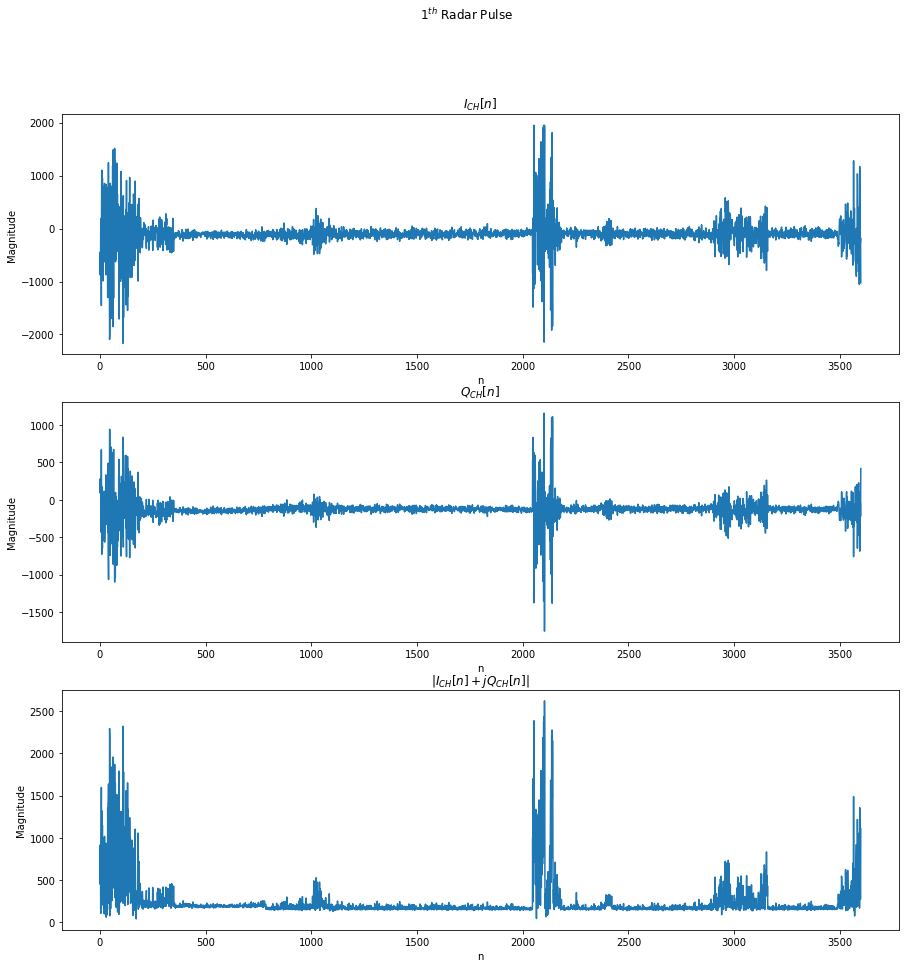

In [13]:
plot_pulse(1)

### plot for the $20^{th}$ pulse

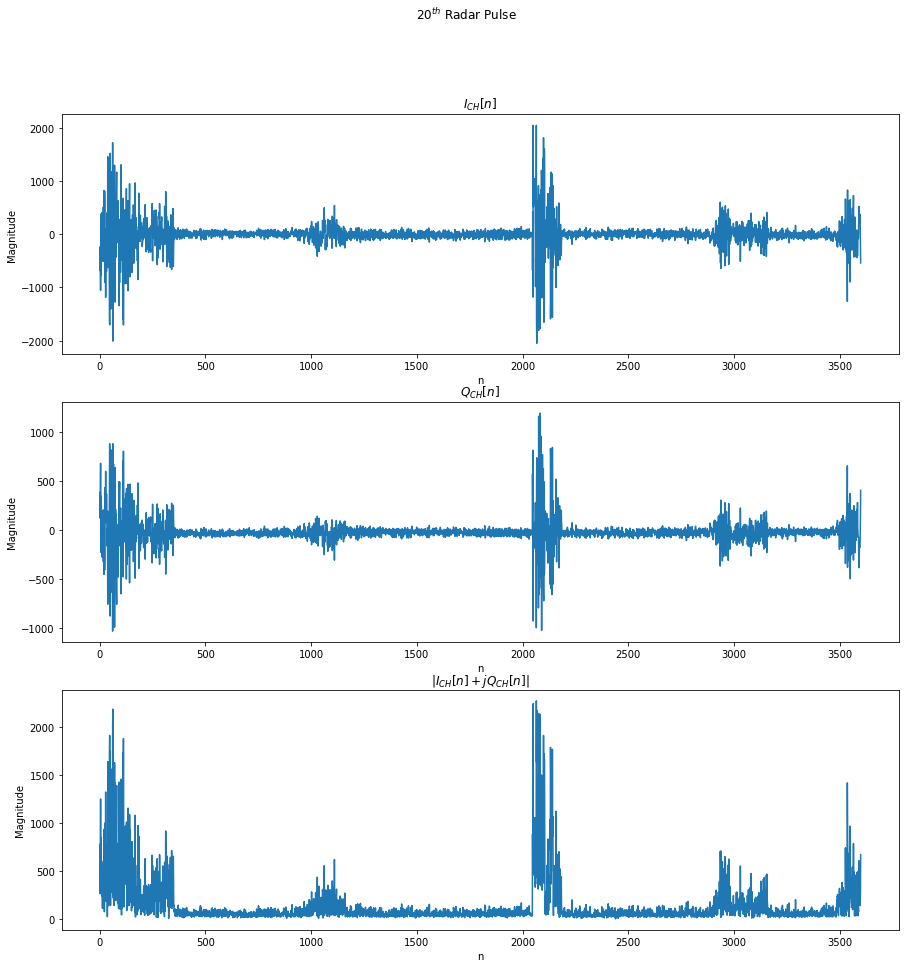

In [14]:
plot_pulse(20)

### plot for the $50^{th}$ pulse

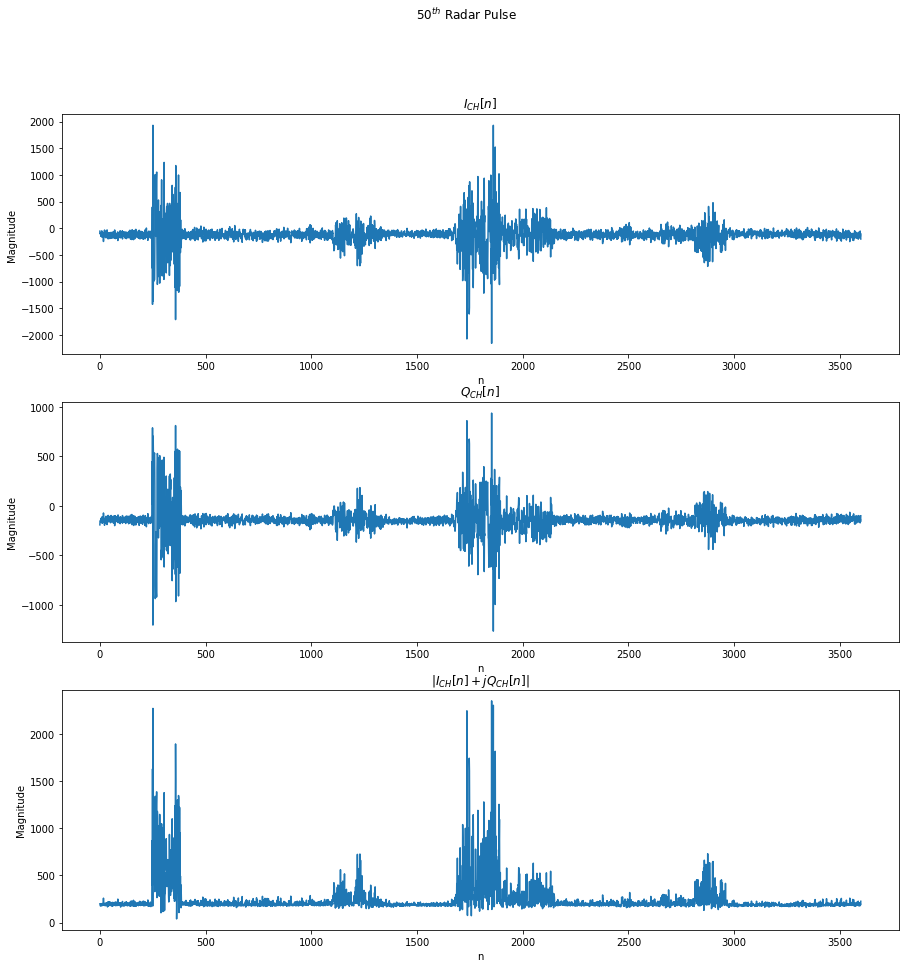

In [15]:
plot_pulse(50)

* As it can be seen, all these pulse echoes consist of collusions as a form of clutter. 

# Q3
## choosing a Bandwidth

By inspecting the previously generated plots, a custom threshold is derived

In [16]:
threshold = 250

#Q4
* The actual samples per pulse is 3600. 

* However from the radar sample whose pulse repetition interval is $900\mu s$, the actual pulse transmission and reception is only done in the first $600\mu s$ and the other $300\mu s$ is used for other processing work. Also the $600\mu s$ also includes the radar blind period in which the width of the transmitted pulse is $14\mu s$.

* $\therefore$ we have to select only the portion of the data matrix that depicts the information regarding clutter data. 

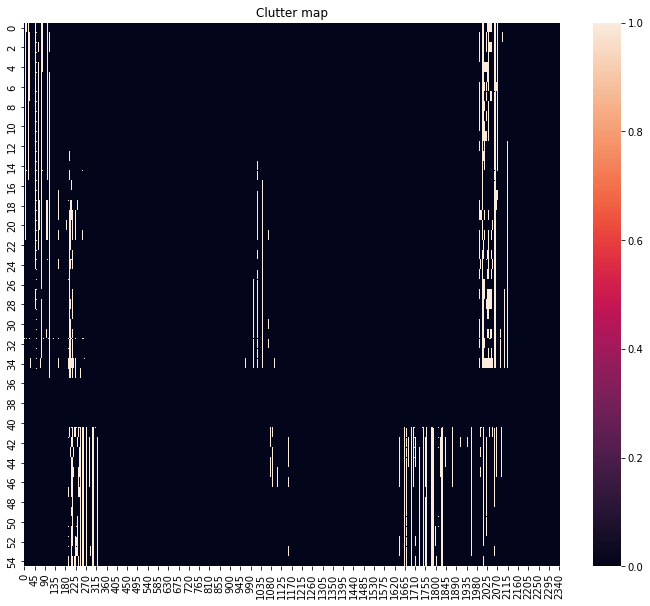

In [17]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title("Clutter map")
sns.heatmap(data_matrix[:, int(radar_blind_period*sampling_rate) : int(transceiver_interval*sampling_rate)]>threshold)

* As it is stated that at this moment in time there are no moving targets in the vicnity of the radar, all the objects / the echoes that have received with high amplitude should assumed to be of various clutters in the environment. Hence the heatmap shows the clutter map

#Q5

## i. RPM of the Radar
The ACP pulses during one revolution and the oversampled radar signals per ACP signal are given. Hence,

$\begin{aligned} \\
revolution\ period &= ACP\ pulses\ per\ revolution \times \frac{oversamples\ per\ ACP}{oversampling\ factor} \times \frac{1}{sampling\ rate}\\
&= \frac{4096 \times 22500}{5 \times 4 \times 10^{6}}\\
&= 4.61 s\\
RPM &= \frac{1}{revolution\ period} \times 60\\
&= \frac{60}{4.608}\\
&= 13.02 rpm
\end{aligned}$

In [18]:
revolution_time = ACP_pulses_per_revolution * (oversamples_per_ACP / oversampling_factor) * (1/ sampling_rate)

RPM = (1/revolution_time) * 60
print("{0:3.2f} RPM".format(RPM))

13.02 RPM


## ii. Number of Echoes per CPI interval

This can be calculated using the paramters ACPs per CPIs, the oversampled radar signals per ACP signal and number of samples per echo. Hence,

$\begin{aligned} \\
Number\ of\ Echoes\ per\ CPI\ interval &= ACPs\ per\ CPI \times \frac{oversamples\ per\ ACP}{oversampling\ factor} \times \frac{1}{samping\ rate \times pulse\ repetition\ interval}\\
&= \frac{32 \times 22500}{5 \times 4 \times 10^6 \times 900 \times 10^{-6}}\\
&= 40
\end{aligned}$

In [19]:
Number_of_Echoes_per_CPI_interval = ACPs_in_CPI * (oversamples_per_ACP / oversampling_factor) * (1/ (sampling_rate * pulse_rep_interval))
print(int(Number_of_Echoes_per_CPI_interval), "Echoes/CPI")

40 Echoes/CPI


## iii. Beam Width

A CPI forms one azimuth bin that corresponding with the antenna bandwidth and there are 128 CPIs during one revolution of the antenna. Hence,

$\begin{aligned} \\
beam\ width &= \frac{360^\circ}{CPIs\ per\ revolution}\\
&=  \frac{360^\circ}{128}\\
&= 2.81^\circ\\
\end{aligned}$


In [20]:
beam_width = 360 / CPIs_per_revolution
print("{0:3.2f} degrees".format(beam_width))

2.81 degrees


# Q6

## general interpretation from the heatmap

we have some clearly strange information while observing the heatmap. 
* The shaft encoder produce pulses at a constant frequency, we can safely assume that the radar is moving at a constant angular velocity. 
* It is known that at this moment in time there are no moving targets in the vicinity of the radar. Therefore all the objects present in the vicinity of the radar would be less significant clutters. 
* With this idea, the first 35 pulses it is observed that these are clutters.  
* Then from pulse 36 to pulse 41, suddenly there is no clutters and all the echoes are lower than the noise threshold. This further needs to be analyzed!! 
* The final set of pulses again shows some clutters, but this time the position of such clutters are different compared to first set of clutters. 



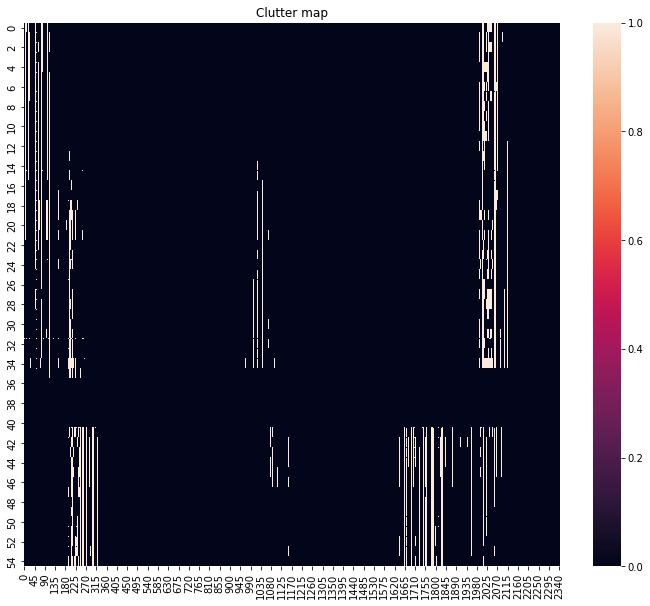

## Interpretation for the anomaly in the set of 36-41 pulses
* One interpretation of the anomaly could be that, due to movement in the radar, suddenly a complete change in the surrounding is detected. However this interpretation could not be true due to the slow angular velocity, change in the azimuth horizontal beam is neglibile for such small period of time. 
* A more rational interpretation could be that suddenly the transmitter was switched off or malfunctioned for the time period. This can be justified by, 
  
  * From the heatmap, as explained earlier there is no clutters for the period of concern. This is due to the radar vicinity not being illuminated by the transmitter. Therefore all the incoming echoes were simply white noise. 






Let's check if there is a shift in the cluttermap from initial working transmitter time to last set of pulses. 

In [21]:
def plot_train(start = 0, end = 55):
  fig, ax = plt.subplots(figsize = (20,5))
  plt.plot(np.abs(W)[start * samples_per_pulse : end * samples_per_pulse], label='radar data')

  # define the pulse train
  echo_pulse_train = np.zeros(len(W[start * samples_per_pulse : end * samples_per_pulse])) 
  for i in range(len(W[start * samples_per_pulse : end * samples_per_pulse])):
    if not i%3600:
      echo_pulse_train[i]=2800

  plt.plot(echo_pulse_train[start * samples_per_pulse : end * samples_per_pulse], label='echo pulses')

  ax.set_title('radar pulse train')
  ax.set( ylabel='Magnitude')
  plt.legend(loc='upper right')
  plt.show()

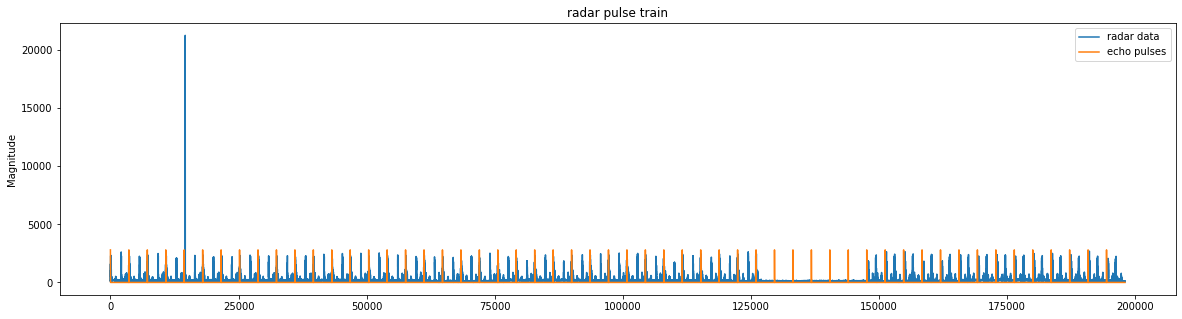

In [22]:
plot_train()

* As expected there is no clutters during the transmitter OFF period.
* Let's further analyse that region

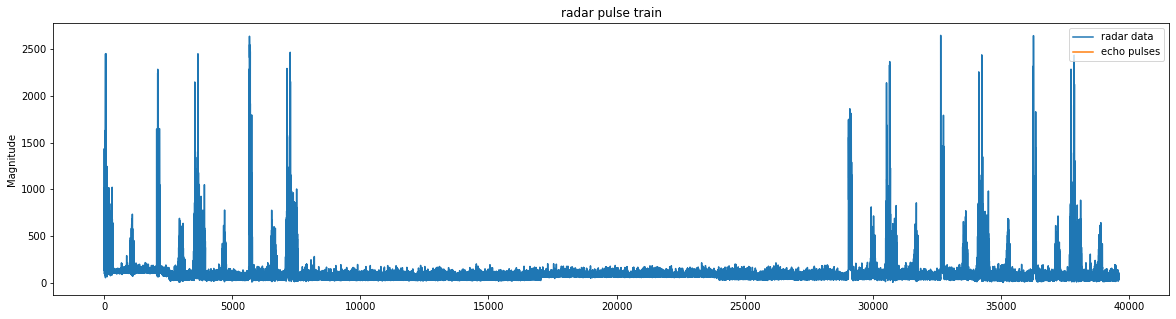

In [23]:
plot_train(33, 44)

* As clearly seen, there is a shift in the cluttermap after the OFF period(36-41 pulse period). 
* This change can be interpreted as below,

  * If the tranmitter was turned on between the $900\mu s$ interval, since the sampling of the signal was not altered, now the sampling of the subsequent pulses would be different compared to the previous sampling. 
  * From the above plot, as we can see there is a shift in cluttermap. Therefore we can conclude that the transmitter was turned on in the middle of 42nd pulse period and not at the beginning of the 42nd pulse. 

let's analyse the accuracy of the Antenna Shaft Encoder.

In [24]:
def ACP_train(title, start = 0, end = len(ACP)):
  fig, ax = plt.subplots(figsize=(20,5))
  ax.plot(ACP[start:end])
  ax.set_title(title)
  ax.set( ylabel='Magnitude')
  plt.show()

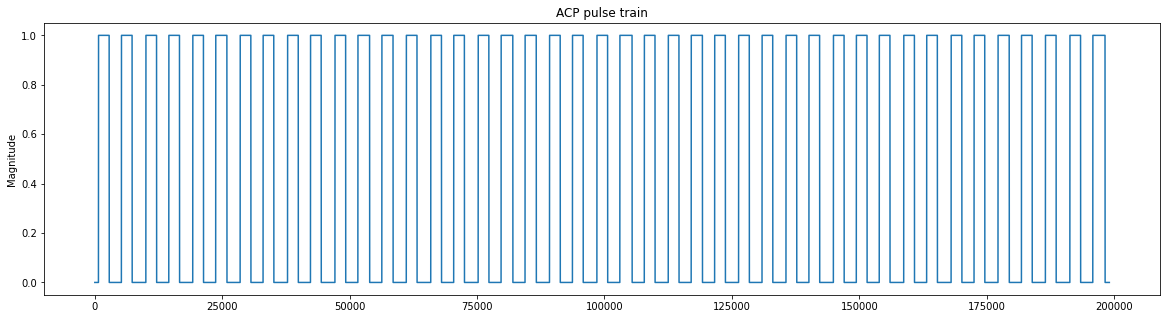

In [25]:
ACP_train('ACP pulse train')

* The shaft Encoder should contain about $\frac{22500}{5} = 5625$ samples per ACP.

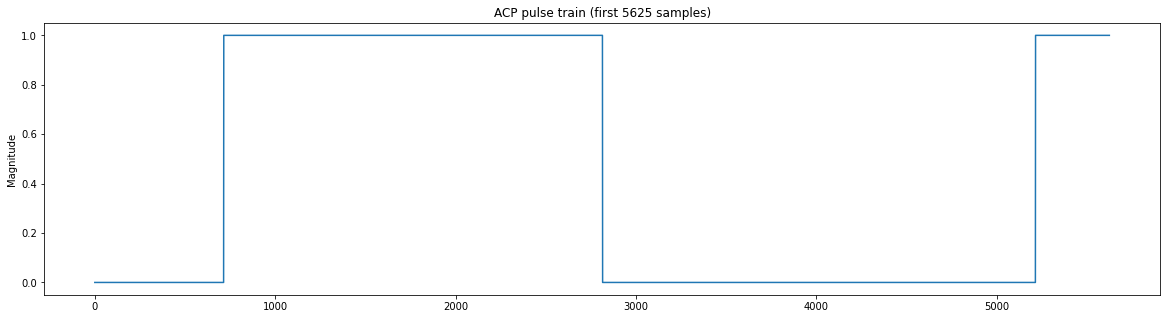

In [26]:
ACP_train('ACP pulse train (first 5625 samples)', 0, 5625)

* let's calculate the period

In [27]:
arr = []
i = 0
for j in range(len(ACP[1:5625])): 
  if (ACP[j]==1 and ACP[i]==0):
    arr.insert(0, j)
  i = j
print("samples per one cycle of ACP encoder : {}".format(arr[0] - arr[1]))

samples per one cycle of ACP encoder : 4500


* The is much less compared to expected value of 5625 samples. 

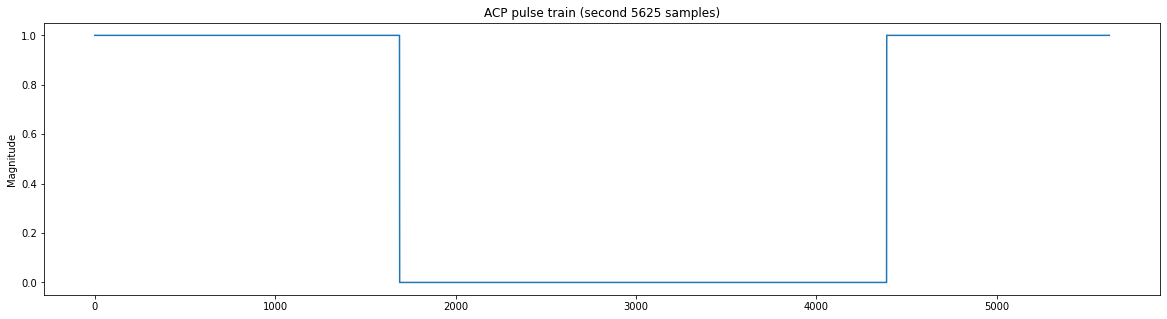

In [28]:
ACP_train('ACP pulse train (second 5625 samples)', 5625, 5625*2)

Clearly the ACP encoder is not properly synced. This could affect the calculations of the radar output. 